In [1]:
import cv2
import mediapipe as mp
import urllib.request as urlreq
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse, Rectangle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from glob import glob
import pandas as pd

#from rembg import remove

from config import *
from cropping import *
from landmarks_utils import *
from preprocessing import *
from face_landmarking_model import *
from training import *
import itertools

In [2]:
#x_inp, y_inp, path_list, angles = prepare_training_landmarks()

In [3]:
#save_preprocessed_data(x_inp, y_inp, path_list, angles)

In [20]:
results = {}
valid_results = {}
cached_models = {}
times = {}
projectors = [1]
rotations = [True]
learning_rates = [0.001]
hidden_head_index = [1]
num_parents = [5]
ffn_bias = [True]
template_size = [50]
gray_scale = [False]
template_method = ['cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']#['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR'] #,- 'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
crop_as_template=[True]

hyperparameter_combinations = list(itertools.product(projectors,
                                                     rotations,
                                                     learning_rates,
                                                     num_parents,
                                                     hidden_head_index,
                                                     ffn_bias,
                                                     template_size,
                                                     gray_scale,
                                                     template_method,
                                                     crop_as_template))
i = 0
for num_projectors, rotate, lr, num_parent_landmarks, hidden_head_index, ffn_bias, template_size, gray_scale, template_method, crop_as_template in tqdm(hyperparameter_combinations):
    combination = f"{num_projectors}_{rotate}_{lr}_{num_parent_landmarks}_{hidden_head_index}_{ffn_bias}_{template_size}_{gray_scale}_{template_method}_{crop_as_template}"
    model, optimizers, schedulers, datasets, dataloaders = prepare_trainers(num_parent_landmarks=num_parent_landmarks, 
                                                                            projectors=num_projectors, 
                                                                            rotate=rotate, 
                                                                            lr_projection=0.01,
                                                                            lr_cnn=lr,
                                                                            lr_ffn=0.005,
                                                                            hidden_head_index=hidden_head_index,
                                                                            ffn_bias=ffn_bias,
                                                                            template_size=template_size,
                                                                            gray_scale=gray_scale,
                                                                            template_method=template_method,
                                                                            crop_as_template=crop_as_template
                                                                            )
    cache, main_cache, test_cache, time_cache = train(
        model,
        optimizers,
        schedulers, 
        datasets, 
        dataloaders, 
        pretrain_epochs=150,
        cnn_epochs=1,
        ffn_epochs=0,
        all_train_epochs=0
        )
    
    results[combination] = cache
    valid_results[combination] = test_cache
    cached_models[combination] = model
    times[combination] = time_cache
    i+=1
            

  0%|          | 0/3 [00:00<?, ?it/s]

Preparing masks and templates...
Preparing model, optimizers, datasets and dataloaders...
Start training!
Pre-training epoch: 149, loss: 0.00010813790140673518.
 Freezing raw_projection, training second module (CNN/template_match).


 33%|███▎      | 1/3 [19:59<39:58, 1199.45s/it]

Preparing masks and templates...
Preparing model, optimizers, datasets and dataloaders...
Start training!
Pre-training epoch: 149, loss: 0.00010603553528198972.
 Freezing raw_projection, training second module (CNN/template_match).


 67%|██████▋   | 2/3 [38:20<19:01, 1141.78s/it]

Preparing masks and templates...
Preparing model, optimizers, datasets and dataloaders...
Start training!
Pre-training epoch: 149, loss: 0.00010129827569471672.
 Freezing raw_projection, training second module (CNN/template_match).


100%|██████████| 3/3 [58:37<00:00, 1172.42s/it]


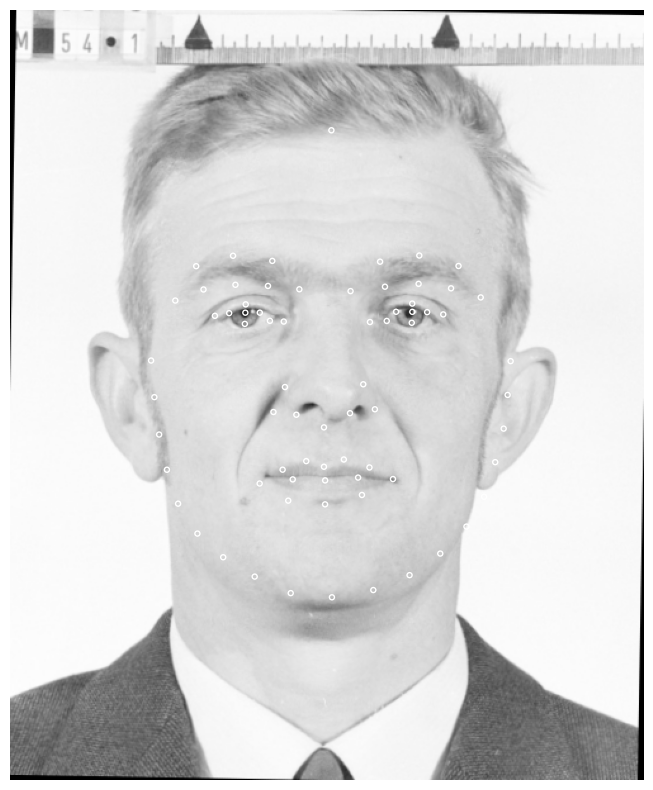

In [54]:
dataset = datasets['main']
dataset.pretraining = False
dataset.work = True
idx = torch.randint(dataset.__len__(),(1,))
batch = dataset.__getitem__(idx)
x, y, multicrop, subimage , image = batch
template = dataset.template
output, input, subimage = model.predict(image)
display_landmarks(output, subimage, pixel_scale=False, origin='upper_left')

In [55]:
import plotly.graph_objs as go
import plotly.express as px

fig = go.Figure()

for combination, losses in results.items():
    scatter = go.Scatter(
        x=list(range(len(losses)))[50:],
        y=losses[50:],
        mode='lines',
        name=combination,
        hovertext=combination
        )
    
    fig.add_trace(scatter)

fig.show()

In [56]:

fig = go.Figure()

for combination, losses in valid_results.items():
    scatter = go.Scatter(
        x=list(range(len(losses))),
        y=losses,
        mode='lines',
        name=combination,
        hovertext=combination
        )
    
    fig.add_trace(scatter)

fig.show()

In [8]:
cached_models.keys()

dict_keys(['1_True_0.001_5_1_True_50_False_cv2.TM_CCOEFF_True', '1_True_0.001_5_1_True_50_False_cv2.TM_CCOEFF_NORMED_True', '1_True_0.001_5_1_True_50_False_cv2.TM_CCORR_True'])

In [9]:
model = cached_models['1_True_0.01_5_3_True_20']

KeyError: '1_True_0.01_5_3_True_20'

tensor([1571])


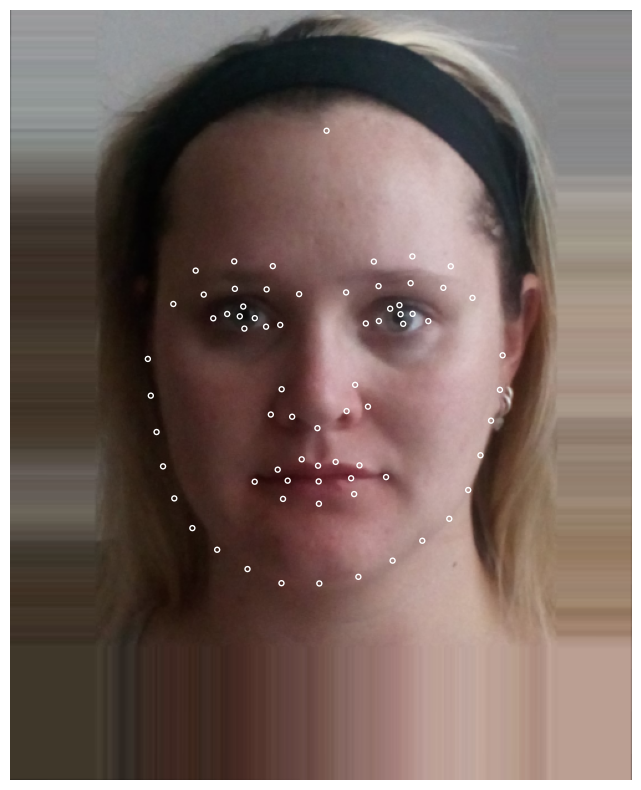

In [ ]:
# zobrazit dva modely na stejném obrázku!
dataset = datasets["test"]
dataset.pretraining = False
idx = torch.randint(dataset.__len__(),(1,))
print(idx)
img_path = dataset.path_list[idx]
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
landmarks, inputs_pathway, image_detail = model.predict(image, face_detail=True)
landmarks = landmarks.reshape(-1,2)
display_landmarks(landmarks, image_detail, pixel_scale=False, origin='upper_left')

# display_landmarks(inputs_pathway.reshape(-1,2), image_detail, pixel_scale=False, origin='upper_left')

In [ ]:
times.keys()

dict_keys(['1_True_0.001_5_1_True_10_False', '1_True_0.001_5_1_True_15_False', '1_True_0.001_5_1_True_20_False', '1_True_0.001_5_1_True_25_False'])

In [ ]:
times['1_True_0.001_5_1_True_25_False']['dataset']

[10.269545555114746,
 10.952800989151001,
 8.786745548248291,
 9.820006847381592,
 9.016602277755737,
 8.04219388961792,
 9.249372482299805,
 15.891115188598633,
 13.934621572494507,
 12.70701265335083,
 13.526884078979492,
 10.68498682975769,
 10.77863073348999,
 14.4608633518219,
 11.992348432540894,
 13.877232551574707,
 12.542069911956787,
 13.397740364074707,
 15.008324146270752,
 12.831253051757812,
 10.974441289901733,
 13.783362865447998,
 10.30956768989563,
 11.917307376861572,
 14.327982664108276,
 11.748077392578125,
 12.50911569595337,
 8.347543954849243,
 9.81332516670227,
 8.96614933013916,
 7.828982353210449,
 9.190245628356934,
 8.5247642993927,
 7.800158739089966,
 7.63669228553772,
 9.95799732208252,
 7.732408761978149,
 9.286598682403564,
 7.82047176361084,
 8.172459363937378,
 8.802980661392212,
 9.496848821640015,
 7.994102954864502,
 8.664922714233398,
 8.066467523574829,
 8.186755895614624,
 9.083298921585083,
 8.910091161727905,
 8.543561220169067,
 8.8165805339